In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install -U transformers accelerate tqdm torchvision

import os
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from transformers import CLIPModel, CLIPProcessor


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/21

In [9]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from peft import get_peft_model, LoraConfig, TaskType
from transformers import CLIPModel, CLIPProcessor
import torchvision.datasets as datasets
from PIL import Image
import time
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
USE_HALF = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

if USE_HALF:
    clip_model = clip_model.half()

# Proper LoRA configuration for CLIP vision model
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # Add task type
    r=8,                    # Slightly higher rank
    lora_alpha=32,          # Higher alpha for stronger adaptation
    target_modules=[
        # Correct module paths for CLIP vision transformer
        "vision_model.encoder.layers.0.self_attn.q_proj",
        "vision_model.encoder.layers.0.self_attn.v_proj",
        "vision_model.encoder.layers.1.self_attn.q_proj",
        "vision_model.encoder.layers.1.self_attn.v_proj",
        "vision_model.encoder.layers.2.self_attn.q_proj",
        "vision_model.encoder.layers.2.self_attn.v_proj",
        # Add more layers as needed - CLIP-ViT-B has 12 layers
    ],
    lora_dropout=0.1,
    bias="none",
)

#  Apply LoRA to the entire model with correct target modules
clip_model = get_peft_model(clip_model, lora_config)

# Freeze text model explicitly
for name, param in clip_model.named_parameters():
    if "text_model" in name and "lora" not in name.lower():
        param.requires_grad = False

#  Verify LoRA parameters are registered
print("=== LORA VERIFICATION ===")
trainable_params = [(n, p.shape) for n, p in clip_model.named_parameters() if p.requires_grad]
print(f"Total trainable parameters: {len(trainable_params)}")

lora_params = [n for n, p in clip_model.named_parameters() if "lora" in n.lower() and p.requires_grad]
print(f"LoRA parameters: {len(lora_params)}")

if lora_params:
    print("✅ LoRA parameters found:")
    for name in lora_params[:5]:  # Show first 5
        print(f"  {name}")
else:
    print("❌ NO LORA PARAMETERS FOUND!")
    print("Trainable parameters:")
    for name, shape in trainable_params[:10]:
        print(f"  {name}: {shape}")

=== LORA VERIFICATION ===
Total trainable parameters: 12
LoRA parameters: 12
✅ LoRA parameters found:
  base_model.model.vision_model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight
  base_model.model.vision_model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight
  base_model.model.vision_model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight
  base_model.model.vision_model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight
  base_model.model.vision_model.encoder.layers.1.self_attn.v_proj.lora_A.default.weight


In [10]:
# Define descriptive labels for morphology
descriptive_labels = {
    "BAS": "basophil with large granules and segmented nucleus",
    "EBO": "erythroblast with round nucleus and basophilic cytoplasm",
    "EOS": "eosinophil with bilobed nucleus and eosinophilic granules",
    "KSC": "smudge cell lacking intact nucleus",
    "LYA": "atypical lymphocyte with irregular nucleus",
    "LYT": "typical lymphocyte with round nucleus and dense chromatin",
    "MMZ": "metamyelocyte with kidney-shaped nucleus",
    "MOB": "monoblast with fine chromatin and prominent nucleoli",
    "MON": "monocyte with abundant cytoplasm and folded nucleus",
    "MYB": "myelocyte with round eccentric nucleus",
    "MYO": "myeloblast with high nuclear-to-cytoplasmic ratio",
    "NGB": "band neutrophil with horseshoe-shaped nucleus",
    "NGS": "segmented neutrophil with multilobed nucleus",
    "PMB": "promyelocyte with bilobed nucleus and dense granules",
    "PMO": "promyelocyte with azurophilic granules",
    "UNC": "unclassified cell lacking distinct morphology",
    "nan": "unannotated cell"
}

# Dataset setup (replace with your actual path)
dataset_path = "/content/drive/MyDrive/data/PKG - AML-Cytomorphology_LMU"

class AMLImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = Image.open(path).convert("RGB")
        return image, label

def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

# Load dataset
full_dataset = AMLImageFolder(dataset_path)
SUBSET_SIZE = 1000
subset_indices = list(range(SUBSET_SIZE))
train_dataset = Subset(full_dataset, subset_indices)

# ✅ FIXED: Larger batch size for better contrastive learning
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True,  # Increased from 4
    num_workers=2, pin_memory=True, collate_fn=collate_fn
)

In [14]:
NUM_EPOCHS = 5
train_losses = []

clip_model.train()

# Higher learning rate and proper parameter filtering
optimizer = torch.optim.AdamW(
    [p for p in clip_model.parameters() if p.requires_grad],
    lr=5e-4,  # Increased from 1e-4
    weight_decay=0.01
)

#  Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print(f"Starting training with {len(train_loader)} batches per epoch...")

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    start_time = time.time()
    loop = tqdm(train_loader, desc=f"🧪 Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch")

    for step, (images, labels) in enumerate(loop):
        # Get text descriptions
        raw_labels = [full_dataset.classes[label] for label in labels]
        texts = [descriptive_labels.get(lbl, "leukemia cell") for lbl in raw_labels]

        # Process inputs
        inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)
        if USE_HALF:
            inputs = {k: v.half() if v.dtype == torch.float32 else v for k, v in inputs.items()}

        #  Direct feature extraction for PEFT models
        text_embeds = clip_model.get_text_features(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
        )
        image_embeds = clip_model.get_image_features(
            pixel_values=inputs['pixel_values']
        )

        # Get normalized embeddings (remove the outputs.image_embeds reference)
        image_embeds = F.normalize(image_embeds, dim=-1)
        text_embeds = F.normalize(text_embeds, dim=-1)

        # Contrastive loss, Use learnable logit scale
        logit_scale = clip_model.logit_scale.exp()
        logits = torch.matmul(image_embeds, text_embeds.T) * logit_scale

        batch_size = len(images)
        targets = torch.arange(batch_size).to(device)

        # Symmetric loss (both directions)
        loss_i2t = F.cross_entropy(logits, targets)
        loss_t2i = F.cross_entropy(logits.T, targets)
        loss = (loss_i2t + loss_t2i) / 2

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(clip_model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

        #  Check gradient flow every 50 steps
        if step % 50 == 0:
            grad_norms = []
            for name, param in clip_model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    grad_norms.append(param.grad.norm().item())

            if grad_norms:
                avg_grad_norm = sum(grad_norms) / len(grad_norms)
                print(f"Step {step}: Avg gradient norm = {avg_grad_norm:.6f}")
            else:
                print(f"Step {step}: NO GRADIENTS FOUND!")

    # Update learning rate
    scheduler.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f" Epoch {epoch+1} completed — Avg Loss: {avg_loss:.4f} — Time: {time.time() - start_time:.2f} sec")

    # Check if loss is changing
    if epoch > 0:
        loss_change = abs(train_losses[-1] - train_losses[-2])
        print(f"   Loss change from previous epoch: {loss_change:.6f}")

        if loss_change < 1e-6:
            print("⚠️  WARNING: Loss not changing - check training setup!")

Starting training with 125 batches per epoch...


🧪 Epoch 1/5:   1%|          | 1/125 [00:05<12:05,  5.85s/batch, loss=2.38, lr=0.0005]

Step 0: Avg gradient norm = 0.163501


🧪 Epoch 1/5:  41%|████      | 51/125 [02:34<03:48,  3.08s/batch, loss=1.96, lr=0.0005]

Step 50: Avg gradient norm = 0.178322


🧪 Epoch 1/5:  81%|████████  | 101/125 [04:58<01:09,  2.91s/batch, loss=1.63, lr=0.0005]

Step 100: Avg gradient norm = 0.180304


🧪 Epoch 1/5: 100%|██████████| 125/125 [06:09<00:00,  2.96s/batch, loss=1.54, lr=0.0005]


✅ Epoch 1 completed — Avg Loss: 1.9049 — Time: 369.88 sec


🧪 Epoch 2/5:   1%|          | 1/125 [00:03<06:59,  3.38s/batch, loss=1.87, lr=0.000452]

Step 0: Avg gradient norm = 0.171016


🧪 Epoch 2/5:  41%|████      | 51/125 [02:35<03:58,  3.22s/batch, loss=1.76, lr=0.000452]

Step 50: Avg gradient norm = 0.193849


🧪 Epoch 2/5:  81%|████████  | 101/125 [05:00<01:07,  2.80s/batch, loss=1.32, lr=0.000452]

Step 100: Avg gradient norm = 0.193718


🧪 Epoch 2/5: 100%|██████████| 125/125 [06:10<00:00,  2.97s/batch, loss=1.74, lr=0.000452]


✅ Epoch 2 completed — Avg Loss: 1.5950 — Time: 370.83 sec
   Loss change from previous epoch: 0.309844


🧪 Epoch 3/5:   1%|          | 1/125 [00:04<09:19,  4.52s/batch, loss=1.38, lr=0.000327]

Step 0: Avg gradient norm = 0.184387


🧪 Epoch 3/5:  41%|████      | 51/125 [02:27<03:26,  2.79s/batch, loss=1.51, lr=0.000327]

Step 50: Avg gradient norm = 0.199254


🧪 Epoch 3/5:  81%|████████  | 101/125 [04:58<01:10,  2.93s/batch, loss=1.33, lr=0.000327]

Step 100: Avg gradient norm = 0.193425


🧪 Epoch 3/5: 100%|██████████| 125/125 [06:08<00:00,  2.95s/batch, loss=1.58, lr=0.000327]


✅ Epoch 3 completed — Avg Loss: 1.4777 — Time: 368.39 sec
   Loss change from previous epoch: 0.117355


🧪 Epoch 4/5:   1%|          | 1/125 [00:03<07:00,  3.39s/batch, loss=1.4, lr=0.000173]

Step 0: Avg gradient norm = 0.189065


🧪 Epoch 4/5:  41%|████      | 51/125 [02:27<03:41,  3.00s/batch, loss=1.26, lr=0.000173]

Step 50: Avg gradient norm = 0.193053


🧪 Epoch 4/5:  81%|████████  | 101/125 [04:52<01:05,  2.74s/batch, loss=1.4, lr=0.000173]

Step 100: Avg gradient norm = 0.192472


🧪 Epoch 4/5: 100%|██████████| 125/125 [06:01<00:00,  2.89s/batch, loss=1.47, lr=0.000173]


✅ Epoch 4 completed — Avg Loss: 1.3880 — Time: 361.30 sec
   Loss change from previous epoch: 0.089664


🧪 Epoch 5/5:   1%|          | 1/125 [00:04<08:58,  4.34s/batch, loss=1.51, lr=4.77e-5]

Step 0: Avg gradient norm = 0.203823


🧪 Epoch 5/5:  41%|████      | 51/125 [02:33<03:33,  2.89s/batch, loss=1.23, lr=4.77e-5]

Step 50: Avg gradient norm = 0.208536


🧪 Epoch 5/5:  81%|████████  | 101/125 [05:00<01:10,  2.94s/batch, loss=1.27, lr=4.77e-5]

Step 100: Avg gradient norm = 0.209080


🧪 Epoch 5/5: 100%|██████████| 125/125 [06:09<00:00,  2.95s/batch, loss=1.01, lr=4.77e-5]

✅ Epoch 5 completed — Avg Loss: 1.3056 — Time: 369.15 sec
   Loss change from previous epoch: 0.082428


Saving LoRA adapter...
✅ Training completed and model saved!

=== FINAL VERIFICATION ===
Final trainable parameters: 12


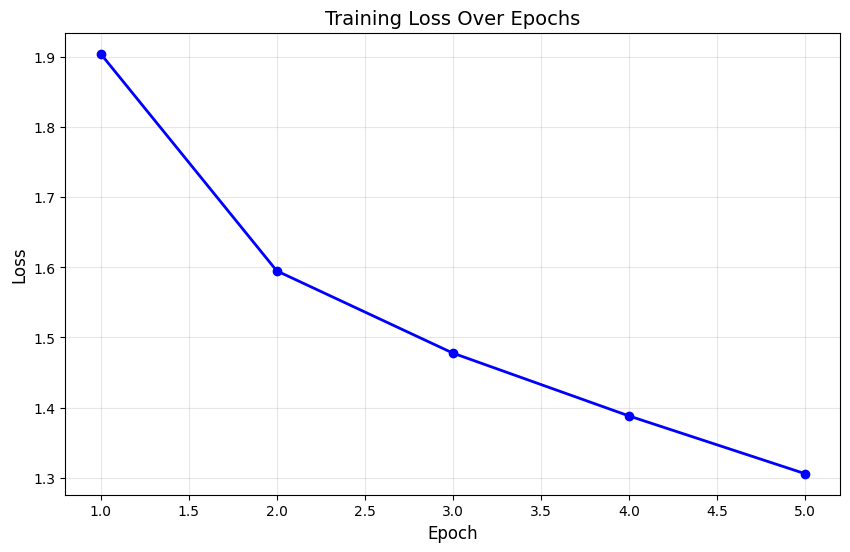

Loss progression: [1.9048872804641723, 1.595043719291687, 1.4776889114379883, 1.3880244545936584, 1.3055967350006104]


In [15]:
# Save the LoRA adapter
print("Saving LoRA adapter...")
clip_model.save_pretrained("/content/drive/MyDrive/fine_tuned_clip_lora_fixed")
print("✅ Training completed and model saved!")

# Final verification
print("\n=== FINAL VERIFICATION ===")
final_params = [(n, p.shape) for n, p in clip_model.named_parameters() if p.requires_grad]
print(f"Final trainable parameters: {len(final_params)}")

# Plot training curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', marker='o', linewidth=2, markersize=6)
plt.title('Training Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Loss progression: {train_losses}")

In [16]:
save_path = "/content/drive/MyDrive/fine_tuned_clip_lora_descriptive"
os.makedirs(save_path, exist_ok=True)

torch.save(clip_model.vision_model.state_dict(), f"{save_path}/pytorch_model.bin")
print(f"✅ Fine-tuned vision model saved to: {save_path}")


✅ Fine-tuned vision model saved to: /content/drive/MyDrive/fine_tuned_clip_lora_descriptive
